In [1]:
import numpy as np 
import pandas as pd 
import datetime 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import r2_score 

___
# Connect to the API and Import Data
* Import the IVolatility API library and set your login details

In [2]:
import ivolatility as ivol 

ivol.setLoginParams(username = 'your_IVol_username', password = 'your_IVol_username')

* Set the methods to import equity prices (**/equities/eod/stock-prices**) and implied volatility (**/equities/eod/ivx**) data

In [3]:
getMarketData = ivol.setMethod('/equities/eod/stock-prices')
getIVX = ivol.setMethod('/equities/eod/ivx')

* Set the query parameters:
   * instruments
   * start/end dates

In [4]:
instruments = {'AAPL': 'Apple', 'MSFT': 'Microsoft', 'AMZN' : 'Amazon', 'GOOG': 'Google', 'META': 'Facebook', \
               'NFLX': 'Netflix' , 'NVDA': 'NVIDIA', 'SPX': 'SP500', 'NDX': 'NASDAQ'}

start = '2020-07-01'
end   = '2021-06-30'

aggregate_marketData = pd.DataFrame()
aggregate_IVX = pd.DataFrame()

* Start populating the equity and implied volatility dataframes, by extracting:
   * close prices for equities, and
   * 360-day (one-year) implied volatility
* We will use **date** as the index in the resulting dataframes

In [5]:
for ticker, instrument in instruments.items():
    print('Loading market data for instrument {} with ticker = {}'.format(instrument, ticker))
    marketData = getMarketData(symbol=ticker, from_=start, to=end)[['date', 'close']]
    marketData['date'] = pd.to_datetime(marketData['date'])
    marketData = marketData.sort_values(by='date')
    marketData = marketData.set_index('date')
    marketData.columns = [ticker]

    #Using 360d (1-year) IV as the stock volatility
    IVX = getIVX(symbol=ticker, from_=start, to=end)[['date', '360d_iv_mean']]
    IVX['date'] = pd.to_datetime(IVX['date'])
    IVX = IVX.sort_values(by='date')
    IVX = IVX.set_index('date')
    IVX.columns = [ticker]

    if aggregate_marketData.empty:
        aggregate_marketData = marketData
        aggregate_IVX = IVX
    else:
        aggregate_marketData = pd.merge(aggregate_marketData, marketData, how='outer', on=['date'])
        aggregate_IVX = pd.merge(aggregate_IVX, IVX, how='outer', on=['date'])

aggregate_marketData = aggregate_marketData.dropna().sort_index()
aggregate_IVX = aggregate_IVX.dropna().sort_index()

Loading market data for instrument Apple with ticker = AAPL
Loading market data for instrument Microsoft with ticker = MSFT
Loading market data for instrument Amazon with ticker = AMZN
Loading market data for instrument Google with ticker = GOOG
Loading market data for instrument Facebook with ticker = META
Loading market data for instrument Netflix with ticker = NFLX
Loading market data for instrument NVIDIA with ticker = NVDA
Loading market data for instrument SP500 with ticker = SPX
Loading market data for instrument NASDAQ with ticker = NDX


* Optionally, you may choose to save the results in a csv file

In [6]:
#aggregate_marketData.to_csv('marketData.csv')
#aggregate_IVX.to_csv('IVX.csv')

___
### Plot closing prices

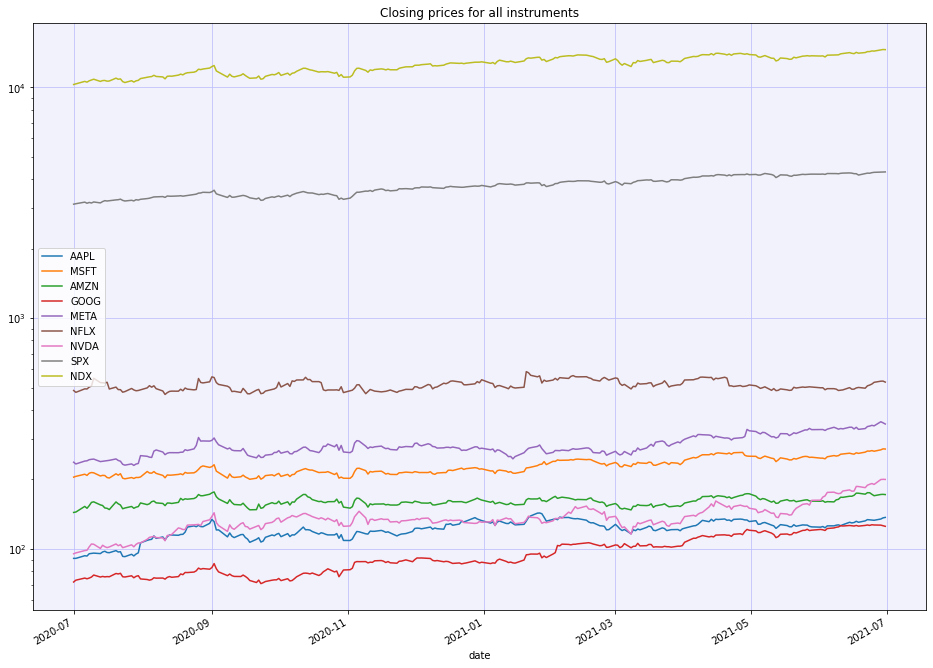

In [7]:
fig, ax = plt.subplots(figsize=(16,12))
aggregate_marketData.plot(ax=plt.gca(), grid=True)
ax.set_yscale('log')
ax.set_title('Closing prices for all instruments')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

___
# Risk & Return of instruments in the portfolio

> Calculate:
   * daily log returns for each instrument
   * average annual log returns
   * average annual impolied volatility
   * correlation matrix

In [8]:
log_returns = np.log(1 + aggregate_marketData.pct_change()).dropna(how='all')
APY_avg = [log_returns[x].mean()*252 for x in log_returns]
IVX_avg = [aggregate_IVX[x].mean() for x in aggregate_IVX]
corr_mat = log_returns.corr()

___
### Plot risk vs return

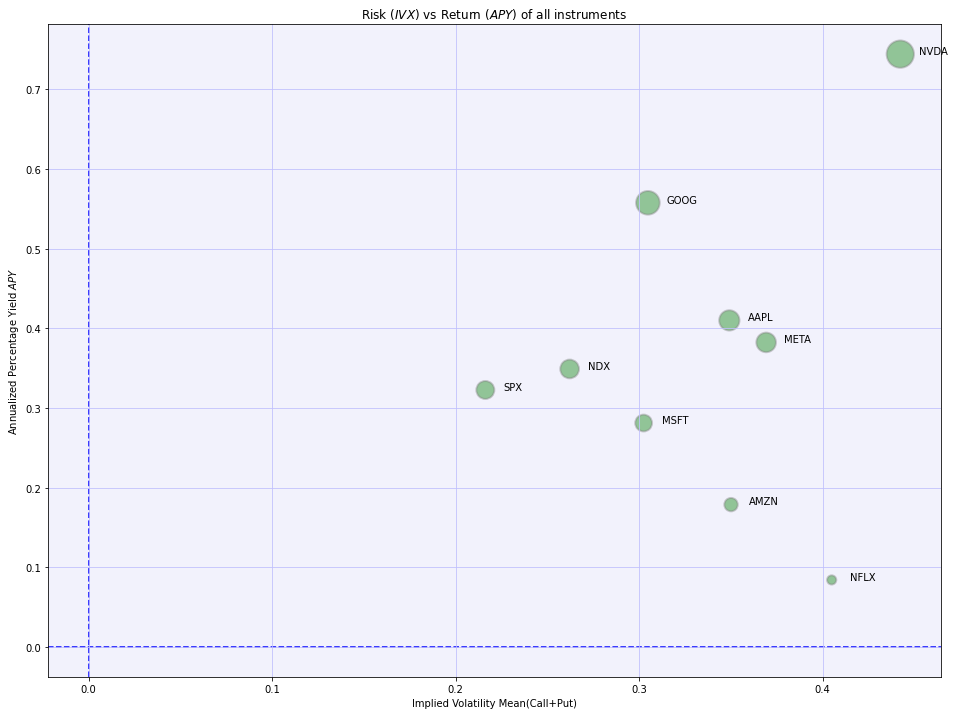

In [9]:
#Configuration - generate different sizes & use green/red for positive/negative returns, respectively
colors = ['red' if x < 0 else 'green' for x in APY_avg]
sizes = list(map(lambda x : abs(x) * 1000, APY_avg))

fig, ax = plt.subplots(figsize = (16,12))
ax.set_title(r'Risk ($IVX$) vs Return ($APY$) of all instruments')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))
ax.set_xlabel(r'Implied Volatility Mean(Call+Put)')
ax.set_ylabel(r'Annualized Percentage Yield $APY$')
ax.scatter(IVX_avg, APY_avg, s = sizes, c = colors, cmap = 'Blues', alpha = 0.4, edgecolors = 'grey', linewidth = 2)
ax.axhline(y = 0.0, xmin = 0, xmax = 5, c = 'blue', linewidth = 1.5, zorder = 0, linestyle = 'dashed')
ax.axvline(x = 0.0, ymin = 0, ymax = 40, c = 'blue', linewidth = 1.5, zorder = 0, linestyle = 'dashed')
for idx, instr in enumerate(list(aggregate_IVX.columns)):
    ax.annotate(instr, (IVX_avg[idx] + 0.01, APY_avg[idx]))
plt.show()

___
### Visualize the correlation matrix in a heatmap

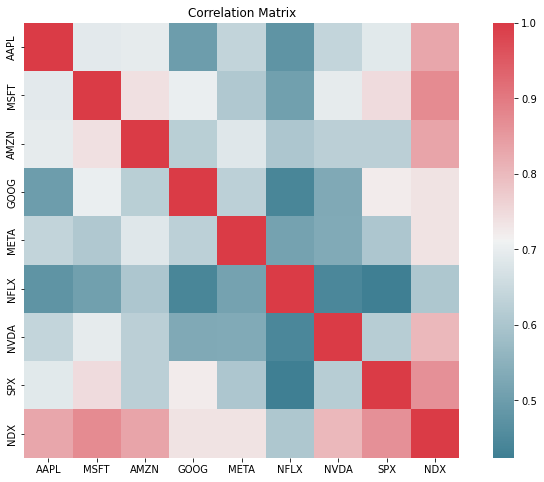

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title(r'Correlation Matrix')
sns.heatmap(corr_mat, mask=np.zeros_like(corr_mat, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
plt.show()

___
# Additional Statistics (Risk & Return Analysis) — Capital Asset Pricing Model (CAPM)

##          Expanded Capital Asset Pricing Model 

### $$ E[R] - R_f = α + β \times (E[R_M] - R_f) + 𝜖 $$

\begin{alignat*}{2}
\text{where:}&&\\
& E[R] &&= \text{expected returns of portfolio instruments} \\
& E[R_M] &&= \text{expected market return} \\
& R_f &&= \text{risk-free rate} \\
& α &&= \text{Alpha} \\
& β &&= \text{Beta} \\
& 𝜖 &&= \text{error adjustment}
\end{alignat*}

In [11]:
def CAPM(APR_avg, APR_avg_market, sigma_avg, sigma_avg_market, risk_free, corr):
    APR_premium        = APR_avg - risk_free
    APR_market_premium = APR_avg_market - risk_free

    #Calculate α, β
    beta  = corr * sigma_avg / sigma_avg_market
    alpha = APR_premium - beta * APR_market_premium 

    return alpha, beta

def visualize_statistic(statistic, tickers, title, limit = 0):
    # Configuration
    fig, ax = plt.subplots(figsize = (12,8))
    ax.set_facecolor((0.95, 0.95, 0.99))
    ax.grid(c = (0.75, 0.75, 0.99), axis = 'y')
    colors = sns.color_palette('Reds', n_colors = len(statistic))
    barlist = ax.bar(x = np.arange(len(statistic)), height =  statistic)

    for b, c in zip(barlist, colors):
        b.set_color(c)
    ax.axhline(y = limit, xmin = -1, xmax = 1, c = 'blue', linewidth = 1.5, zorder = 0, linestyle = 'dashed')

    for i, v in enumerate(statistic):
        ax.text( i - 0.22,v + 0.01 , str(round(v,3)), color = 'blue', fontweight='bold')
    plt.xticks(np.arange(len(statistic)), tickers)
    plt.title(r'{} for every instrument with respect to the NASDAQ market'.format(title))
    plt.xlabel(r'Instrument')
    plt.ylabel(r'{} value'.format(title))
    plt.show()

___
Descriptive Statistics
===

___
> Get the risk-free rate from the API, using the **/proxy/interest-rates** method, for the last day of the period we're studying, i.e. parameters **from_** and **till** are equal to date **end**.

> Then select the rate with **period = 1**.

In [12]:
getInterestRates = ivol.setMethod('/proxy/interest-rates')
risk_free_rate = getInterestRates(from_=end, till=end, period=1)
risk_free_rate = float(risk_free_rate.loc[risk_free_rate['period'] == 1, 'rate'])
risk_free_rate

0.08313

___
> Now merge the calculated Risk and Return statistics into a single dataframe

In [13]:
# RETURN
APR_total         = log_returns.groupby([log_returns.index.year]).agg('sum')
APR_avg_total     = APR_total.mean()
APR_avg_market    = APR_avg_total['NDX']
descriptive_stats = pd.DataFrame(APR_avg_total, columns = ['Average APR'])

# RISK
descriptive_stats = pd.merge(descriptive_stats, pd.DataFrame(aggregate_IVX.mean(), columns = ['Average IVX']), left_index=True,  right_index=True, how='inner')
STD_total         = log_returns.groupby([log_returns.index.year]).agg('std') * np.sqrt(252)
STD_avg_total     = STD_total.mean()
STD_avg_market    = STD_avg_total['NDX']
descriptive_stats = pd.merge(descriptive_stats, pd.DataFrame(STD_avg_total, columns = ['Average STD']), left_index=True,  right_index=True, how='inner')

descriptive_stats

,Average APR,Average IVX,Average STD
AAPL,0.204264,0.349213,0.337148
MSFT,0.140102,0.302503,0.264048
AMZN,0.089090,0.350140,0.299751
GOOG,0.277767,0.304828,0.272008
META,0.190495,0.369279,0.342230
NFLX,0.042013,0.404997,0.403308
NVDA,0.370706,0.442395,0.430771
SPX,0.160764,0.216222,0.151374
NDX,0.173899,0.262166,0.228244


___
### Alpha and Beta values
> Using the Expanded CAPM model, get the α and β values for every instrument in our portfolio.

> Since we are using technology stocks, we will be comparing our portfolio to the Nasdaq market

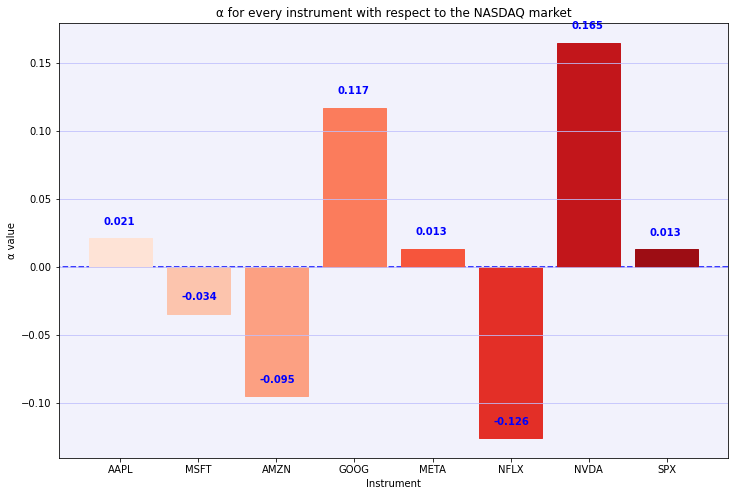

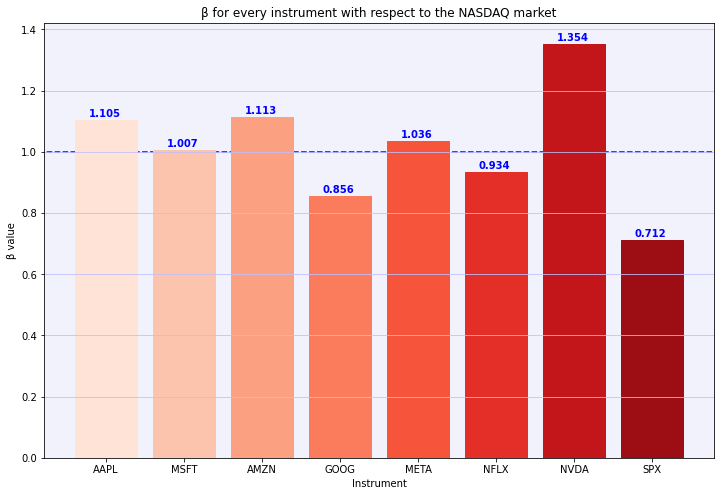

In [14]:
alpha, beta = CAPM(APR_avg = APR_avg_total.drop('NDX'), APR_avg_market = APR_avg_total['NDX'], \
                   sigma_avg = descriptive_stats['Average IVX'].drop('NDX'), \
                   sigma_avg_market = float(descriptive_stats.loc[descriptive_stats.index == 'NDX', 'Average IVX']), \
                   risk_free = risk_free_rate, corr = corr_mat.loc['NDX'].drop('NDX'))
alpha_beta = pd.merge(pd.DataFrame(alpha, columns=['Alpha']), pd.DataFrame(beta, columns=['Beta']), left_index=True,  right_index=True, how='inner')
visualize_statistic(alpha.values, alpha.index, 'α')
visualize_statistic(beta.values, beta.index, 'β', limit = 1)

___
### $R^2$ Scores

In [15]:
r2_scores = {}
for ticker in log_returns.columns:
    r2_scores[ticker] = [r2_score(log_returns[ticker], log_returns['NDX'])]
descriptive_stats = pd.merge(descriptive_stats, pd.DataFrame.from_dict(r2_scores, orient='index', columns = ['R2 Score w.r.t. NDX']).drop('NDX'), left_index=True, right_index=True, how='outer')
descriptive_stats = pd.merge(descriptive_stats, alpha_beta, left_index=True,  right_index=True, how='outer')
descriptive_stats

,Average APR,Average IVX,Average STD,R2 Score w.r.t. NDX,Alpha,Beta
AAPL,0.204264,0.349213,0.337148,0.661732,0.020809,1.105277
AMZN,0.089090,0.350140,0.299751,0.685972,-0.095094,1.113305
GOOG,0.277767,0.304828,0.272008,0.528636,0.116940,0.855986
META,0.190495,0.369279,0.342230,0.535638,0.013358,1.035672
MSFT,0.140102,0.302503,0.264048,0.761761,-0.034473,1.007443
NDX,0.173899,0.262166,0.228244,NaN,NaN,NaN
NFLX,0.042013,0.404997,0.403308,0.362138,-0.125868,0.933702
NVDA,0.370706,0.442395,0.430771,0.567211,0.164701,1.353716
SPX,0.160764,0.216222,0.151374,0.335099,0.012971,0.712392


___
> Print the combined descriptive statistics of our portfolio

In [16]:
portfolio_description = pd.DataFrame(descriptive_stats.mean(), columns=['Portfolio']).T
portfolio_description

,Average APR,Average IVX,Average STD,R2 Score w.r.t. NDX,Alpha,Beta
Portfolio,0.183233,0.333527,0.303209,0.554773,0.009168,1.014687
